GAN Example

The samples do not look good yet but the basics are here

In [1]:
import theano
import numpy as np
import matplotlib.pylab as plt
import csv, os, random, sys

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: GeForce GTX TITAN Black (0000:04:00.0)


theano 0.9.0rc2.dev-674f8d5148cb8dcea446e7243e629d8f83647da5
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
##Uncomment these lines to fetch the dataset
#!wget -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvf cifar-10-python.tar.gz

In [4]:
data_dir_cifar10 = os.path.join(".", "cifar-10-batches-py")

def one_hot(x, n):
    x = np.array(x)
    assert x.ndim == 1
    return np.eye(n)[x]

def _load_batch_cifar10(filename, dtype='float32'):
    path = os.path.join(data_dir_cifar10, filename)
    batch = np.load(path)
    data = batch['data'] / 255.0 # scale between [0, 1]
    labels = one_hot(batch['labels'], n=10) # convert labels to one-hot representation
    return data.astype(dtype), labels.astype(dtype)

def cifar10(dtype='float32', grayscale=True):
    x_train = []
    t_train = []
    for k in xrange(5):
        x, t = _load_batch_cifar10("data_batch_%d" % (k + 1), dtype=dtype)
        x_train.append(x)
        t_train.append(t)

    x_train = np.concatenate(x_train, axis=0)
    t_train = np.concatenate(t_train, axis=0)

    x_test, t_test = _load_batch_cifar10("test_batch", dtype=dtype)

    if grayscale:
        x_train = _grayscale(x_train)
        x_test = _grayscale(x_test)

    return x_train, t_train, x_test, t_test

# load data
x_train, t_train, x_test, t_test = cifar10(dtype=theano.config.floatX,grayscale=False)
labels_test = np.argmax(t_test, axis=1)

print "x_train.shape:",x_train.shape

# reshape data
x_train = x_train.reshape((x_train.shape[0], 3, 32, 32))
x_test = x_test.reshape((x_test.shape[0], 3, 32, 32))

cifar10_names = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']

x_train.shape: (50000, 3072)


In [5]:
# x_train = x_train[:10000]
# t_train = t_train[:10000]

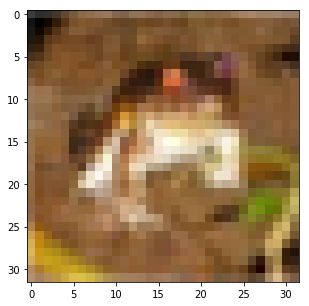

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

In [7]:
num_units = 100
encoder_size = 100
noise_size = 10

In [8]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, MaxPool2DLayer, Upscale2DLayer
from lasagne.layers import ConcatLayer, DropoutLayer, ReshapeLayer, TransposedConv2DLayer

In [346]:
gen_input_var = T.matrix("gen_input_var")

gen = lasagne.layers.InputLayer(shape=(None, noise_size),input_var=gen_input_var)
print gen.output_shape

gen = lasagne.layers.ReshapeLayer(gen, (-1, noise_size, 1, 1))
print gen.output_shape
gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units, filter_size=4, stride=1))
print gen.output_shape

gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units/2, filter_size=6, stride=1))
print gen.output_shape

gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units/2, filter_size=14, stride=1))
print gen.output_shape

gen = TransposedConv2DLayer(gen, num_filters=num_units/4, filter_size=8)
print gen.output_shape

gen = TransposedConv2DLayer(gen, num_filters=3, filter_size=4, nonlinearity=lasagne.nonlinearities.sigmoid)
print gen.output_shape

We have 100 hidden units
(None, 10)
(None, 10, 1, 1)
(None, 100, 4, 4)
(None, 50, 9, 9)
(None, 50, 22, 22)
(None, 25, 29, 29)
(None, 3, 32, 32)


In [347]:
lrelu = lasagne.nonlinearities.LeakyRectify(0.2)

disc = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=None)
print disc.output_shape

disc = BatchNormLayer(Conv2DLayer(disc, num_filters=num_units/4, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = BatchNormLayer(Conv2DLayer(disc, num_filters=num_units/2, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = BatchNormLayer(Conv2DLayer(disc, num_filters=num_units, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = FlattenLayer(disc)
disc = DenseLayer(disc, 1, nonlinearity=lasagne.nonlinearities.sigmoid)
print disc.output_shape

We have 100 hidden units
(None, 3, 32, 32)
(None, 25, 16, 16)
(None, 50, 8, 8)
(None, 100, 4, 4)
(None, 1)


In [375]:
# create train functions 
lr = theano.shared(np.array(0., dtype=theano.config.floatX))

gen_output = lasagne.layers.get_output(gen)

one = T.constant(1., dtype=theano.config.floatX)
input_real = T.tensor4('target')


disc_output_fake = lasagne.layers.get_output(disc, inputs=gen_output)
disc_output_real = lasagne.layers.get_output(disc, inputs=input_real)
disc_loss = -(T.log(disc_output_real) + T.log(one-disc_output_fake)).mean()
disc_params = lasagne.layers.get_all_params(disc, trainable=True)
disc_updates = lasagne.updates.adam(disc_loss, disc_params, learning_rate=lr, beta1=0.5)


gen_loss = -T.log(disc_output_fake).mean()
gen_params = lasagne.layers.get_all_params(gen, trainable=True)
gen_updates = lasagne.updates.adam(gen_loss, gen_params, learning_rate=lr, beta1=0.5)


print "Computing functions"

gen_fn = theano.function([gen_input_var], gen_output, allow_input_downcast=True)

train_gen_fn = theano.function([gen_input_var], 
                               [gen_loss],
                               updates=gen_updates, 
                               allow_input_downcast=True)

disc_fn = theano.function([input_real], disc_output_real, allow_input_downcast=True)

train_disc_fn = theano.function([gen_input_var, input_real], 
                                [disc_loss],
                                updates=disc_updates,
                                allow_input_downcast=True)

print "Done"

Computing the functions...
Done


(1, 3, 32, 32)


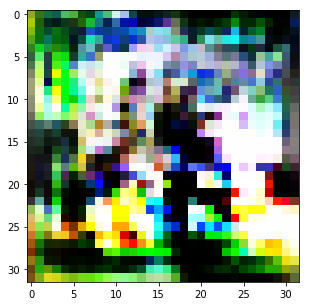

In [455]:
noise = np.random.uniform(size=(1, noise_size))
img = gen_fn(noise)
print img.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(img[0], (1,2,0)),interpolation='none', cmap='gray');

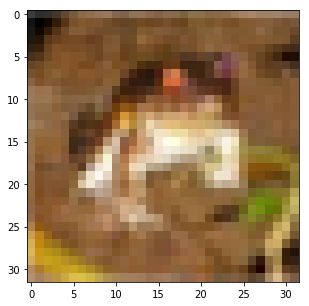

In [451]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

In [461]:
disc_fn(img)

array([[ 0.0025]], dtype=float32)

In [462]:
disc_fn(x_train[:1])

array([[ 0.0394]], dtype=float32)

In [446]:
num_samples = 1000

In [ ]:
# lr.set_value(0.001)
# for i in range(100):
#     errs = []
#     for i in range(10):
#         noise = np.random.normal(size=(num_samples, noise_size))
#         samples = np.random.randint(0,len(x_train),num_samples)
#         err = train_disc_fn(noise, x_train[samples])
#         errs.append(err)
#     print "d",np.mean(errs)

In [ ]:
# lr.set_value(0.001)
# for i in range(1000):
#     errs = []
#     for i in range(5):
#         noise = np.random.normal(size=(num_samples, noise_size))
#         err = train_gen_fn(noise)
#         errs.append(err)
#     print "g",np.mean(errs)

In [ ]:
lr.set_value(0.001)
for j in range(100):
    errs = []
    for i in range(10):
        noise = np.random.normal(size=(num_samples, noise_size))
        samples = np.random.randint(0,len(x_train),num_samples)
        err = train_disc_fn(noise, x_train[samples])
        errs.append(err)
    print "d",np.mean(errs)
    errs = []
    for i in range(1):
        noise = np.random.normal(size=(num_samples, noise_size))
        err = train_gen_fn(noise)
        errs.append(err)
    print "g",np.mean(errs)

(1, 3, 32, 32)


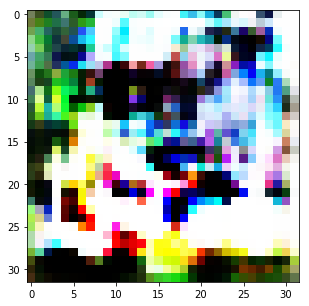

In [464]:
noise = np.random.uniform(size=(1, noise_size))
img = gen_fn(noise)
print img.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(img[0], (1,2,0)),interpolation='none', cmap='gray');